# Monowai CC tests

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import xcorr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib notebook

### open a file

In [6]:
def filename(path:str, r1:dict, r2:dict, time:pd.datetime):
    pair = '-'.join([xcorr.util.receiver_to_str(r1), xcorr.util.receiver_to_str(r2)])
    return os.path.join(path,pair,'{p}.{y:04d}.{d:03d}.nc'.format(p=pair,y=time.year,d=time.dayofyear))

In [7]:
path = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'
time = pd.to_datetime('2015-01-15')

hydro = {
    'network'  : 'IM',
    'station'  : 'H03S1',
    'location' : '',
    'channel'  : 'EDH',
}
seism = {
    'network'  : 'IU',
    'station'  : 'RAR',
    'location' : '10',
    'channel'  : 'BHZ',
}

vel = dict( min=1.46, max=1.50 )

bhz = xcorr.open_dataset(filename(path, hydro, seism, time), fast=True)
bhr = xcorr.open_dataset(filename(path, hydro, {**seism,'channel':'BHR'}, time), fast=True)

assert bhz, 'No data found!'

if bhz:
    xcorr.bias_correct_dataset(bhz,unbiased_var='cc_w')
if bhr:
    xcorr.bias_correct_dataset(bhr,unbiased_var='cc_w')

### CCF noise window

<IPython.core.display.Javascript object>


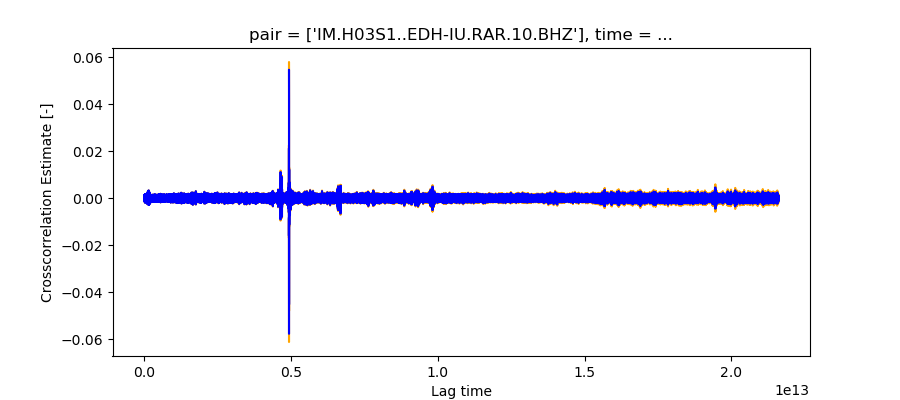

In [8]:
plt.figure(figsize=[9,4])
bhz.cc_w.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='orange')
bhz.cc.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='blue')

In [10]:
lag_s = xcorr.util.to_seconds(bhz.lag)

noise_lim = pd.to_timedelta([bhz.time.window_length * v for v in [.2, .25]], unit='s')
noise_lim_s = xcorr.util.to_seconds(noise_lim)

noise_win = ( lag_s >= noise_lim_s[0] ) & ( lag_s <= noise_lim_s[1] )

signal_lim = pd.to_timedelta((bhz.distance.values[0]/vel['max'],bhz.distance.values[0]/vel['min']), unit = 's' )
signal_lim_s = xcorr.util.to_seconds(signal_lim)

signal_win = ( lag_s >= signal_lim_s[0] ) & ( lag_s <= signal_lim_s[1] )

valid_win = ( abs(lag_s) <= noise_lim_s[1] )

i = 1

print('signal : ', signal_lim)
print('noise  : ', noise_lim)

signal :  TimedeltaIndex(['01:21:16.973764', '01:23:30.589484'], dtype='timedelta64[ns]', freq=None)
noise  :  TimedeltaIndex(['04:48:00', '06:00:00'], dtype='timedelta64[ns]', freq=None)


<IPython.core.display.Javascript object>


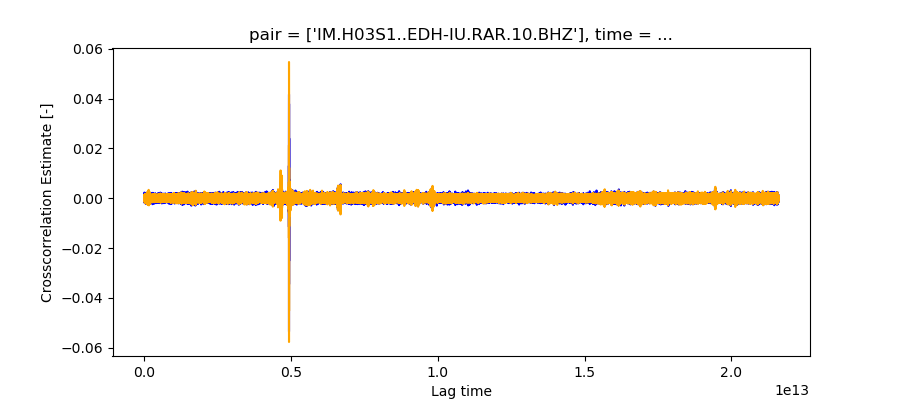

In [11]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


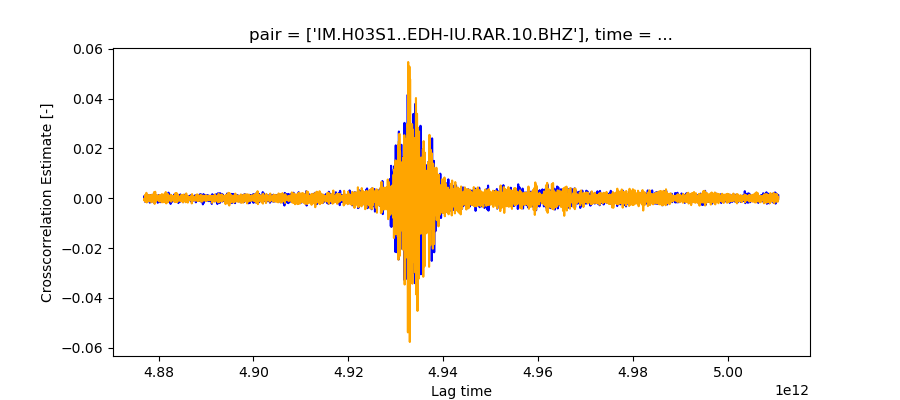

In [12]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


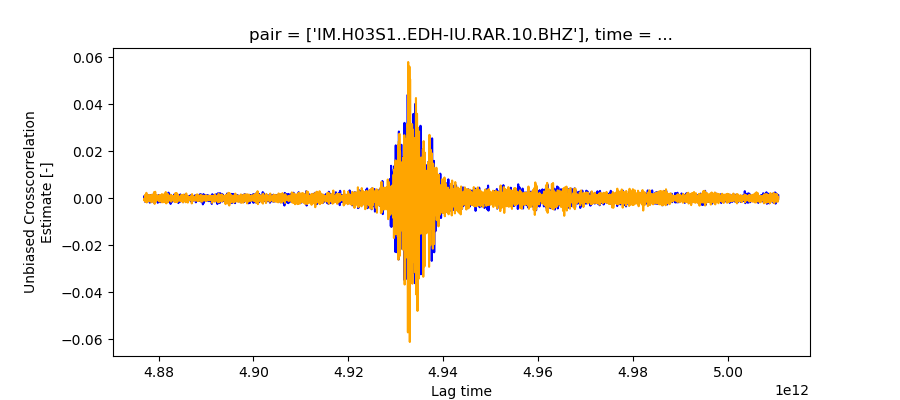

In [13]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


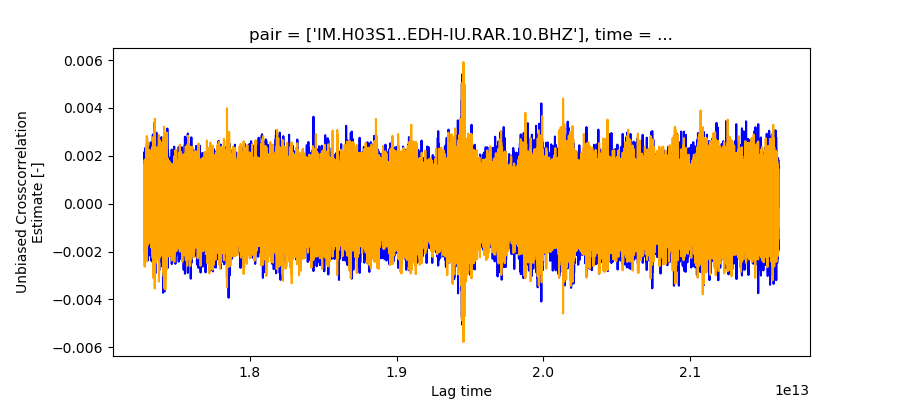

In [14]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [15]:
if bhz:
    bhz['snr'] = ( 
        xcorr.postprocess.rms(bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}]) / 
        xcorr.postprocess.rms(bhz.cc_w.loc[{'lag':bhz.lag[noise_win]}])
    )
    print(bhz.snr)
    
if bhr:
    bhr['snr'] = ( 
        xcorr.postprocess.rms(bhr.cc_w.loc[{'lag':bhr.lag[signal_win]}]) / 
        xcorr.postprocess.rms(bhr.cc_w.loc[{'lag':bhr.lag[noise_win]}])
    )
    print(bhr.snr)

<xarray.DataArray 'snr' (pair: 1, time: 8)>
array([[6.0803795, 5.9655495, 5.5066657, 5.1391964, 5.5193343, 8.9648485,
        7.685458 , 5.8476005]], dtype=float32)
Coordinates:
  * pair     (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHZ'
  * time     (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
<xarray.DataArray 'snr' (pair: 1, time: 8)>
array([[5.321763 , 5.1952467, 4.8507776, 4.5866547, 4.9640493, 7.109305 ,
        5.649668 , 4.114984 ]], dtype=float32)
Coordinates:
  * pair     (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR'
  * time     (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00


### xcorr full day (#8)

<IPython.core.display.Javascript object>


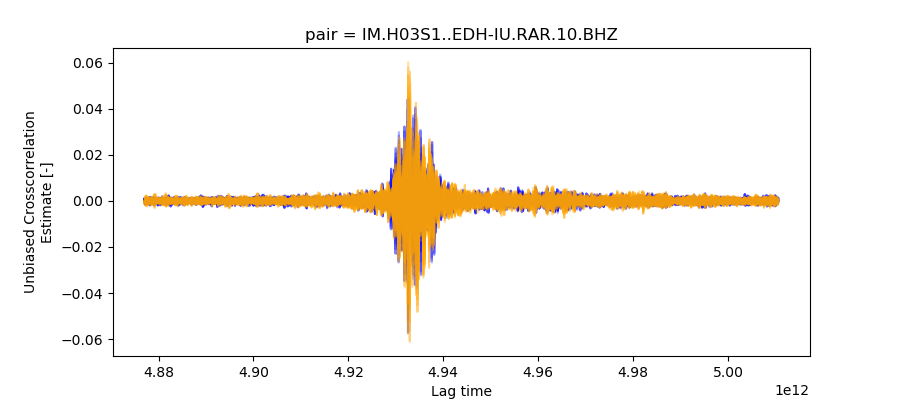

In [16]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhr:
    snr_pass = bhr.snr.loc[{'pair':bhr.pair[0]}] >= snr_min
    if any(snr_pass):
        bhr.cc_w.loc[{
            'time':bhr.time[snr_pass],
            'lag':bhr.lag[signal_win],
            'pair':bhr.pair[0]
        }].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz:
    snr_pass = bhz.snr.loc[{'pair':bhz.pair[0]}] >= snr_min
    if any(snr_pass):
        bhz.cc_w.loc[{
            'time':bhz.time[snr_pass],
            'lag':bhz.lag[signal_win],
            'pair':bhz.pair[0]
        }].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)

## Filter CC

In [74]:
bhz['cc_w_f'] = xcorr.postprocess.filter(bhz.cc_w,btype='bandpass',frequency=[5.,20.])
if bhr:
    bhr['cc_w_f'] = xcorr.postprocess.filter(bhr.cc_w,btype='bandpass',frequency=[5.,20.])

In [75]:
bhr.cc_w_f.history

'xcorr 0.1.dev82+g1145ccb.d20200327: filter({"frequency": [5.0, 20.0], "btype": "bandpass", "order": 2, "dim": "lag", "**kwargs": {}})'

In [66]:
xcorr.write_dataset(bhz,'test.nc')

/Users/psmets/Documents/Research/_progs/_Python/xcorr/xcorr/core/core.py:75: UserWarning: Dataset metadata sha256 hash is inconsistent
  UserWarning


Write dataset as "test.nc": Close. Hash. To temporary netcdf. Replace. Done.


In [67]:
test = xcorr.open_dataset('test.nc')

/Users/psmets/Documents/Research/_progs/_Python/xcorr/xcorr/core/core.py:136: UserWarning: Dataset metadata sha256 hash is inconsistent.
  UserWarning
/Users/psmets/Documents/Research/_progs/_Python/xcorr/xcorr/core/core.py:155: UserWarning: Dataset sha256 hash is inconsistent.
  UserWarning


In [ ]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhr:
    snr_pass = bhr.snr.loc[{'pair':bhr.pair[0]}] >= snr_min
    if any(snr_pass):
        bhr.cc_w_f.loc[{
            'time':bhr.time[snr_pass],
            'lag':bhr.lag[signal_win],
            'pair':bhr.pair[0]
        }].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz:
    snr_pass = bhz.snr.loc[{'pair':bhz.pair[0]}] >= snr_min
    if any(snr_pass):
        bhz.cc_w_f.loc[{
            'time':bhz.time[snr_pass],
            'lag':bhz.lag[signal_win],
            'pair':bhz.pair[0]
        }].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)

In [ ]:
bhz.cc_w_f

## Spectrogram

In [ ]:
psd = xcorr.postprocess.psd(
    bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}],
    duration = 2.,
    padding = 4,
    lag_to_seconds=True
)

In [ ]:
plt.figure()
psd.loc[{'time':psd.time[4],'pair':psd.pair[0]}].plot.imshow(x='lag')

In [ ]:
psd_mean = psd.dropna(dim='lag').sum(dim='time',skipna=True).mean(dim='pair',skipna=True)

In [ ]:
plt.figure()
psd_mean.plot.imshow(x='lag')